# FCC-ee tilted solenoid correction

In [1]:
%matplotlib widget

In [2]:
import xtrack as xt

import matplotlib.pyplot as plt

In [3]:
line = xt.Line.from_json('fccee_z_with_sol.json')

Loading line from dict:   0%|          | 0/81624 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
tw_sol_off = line.twiss4d()

### Tilted solenoid

<div>
<img src="solenoid.png" width="800"/>
</div>

In [5]:
line.vars['on_sol_ip.1'] = 1
tw_sol_on = line.twiss(method='4d')

**Beta beating**

Text(0.5, 0, 's [m]')

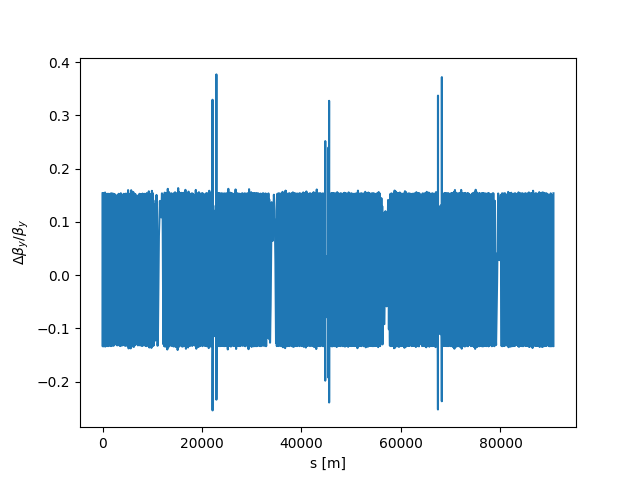

In [6]:
plt.figure()
plt.plot(tw_sol_off.s, tw_sol_on.bety/tw_sol_off.bety - 1)
plt.ylabel(r'$\Delta \beta_y / \beta_y$')
plt.xlabel('s [m]')

In [7]:
tw_sol_on.c_minus

0.00032023446410065095

Text(0.5, 0, 's [m]')

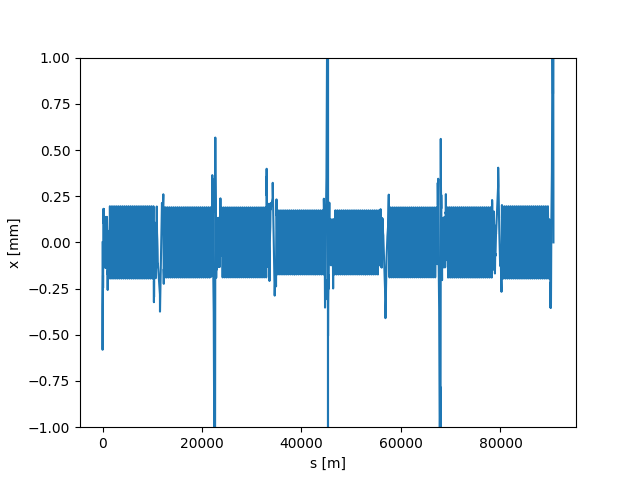

In [8]:
plt.figure()
plt.plot(tw_sol_off.s, tw_sol_on.x*1e3)
plt.ylim(-1, 1)
plt.ylabel('x [mm]')
plt.xlabel('s [m]')

## Correct locally orbit, coupling and optics

#### Correction strategy for the right side

In [9]:
opt_r = line.match(
    solve=False,
    method='4d', n_steps_max=30,
    start='ip.1', end='pqc2re.1',
    init=tw_sol_off, init_at=xt.END, # Matching backward
    vary=[
        xt.VaryList(['acb1h.r1', 'acb2h.r1','acb1v.r1', 'acb2v.r1'], step=1e-8, tag='corr_r'),            # dipole corr
        xt.VaryList(['ks1.r1', 'ks2.r1', 'ks3.r1', 'ks0.r1'], step=1e-7, tag='skew_r'),                   # skeq quad
        xt.VaryList(['corr_k1.r1', 'corr_k2.r1', 'corr_k3.r1', 'corr_k0.r1'], step=1e-6, tag='normal_r'), # norm quad
    ],
    targets=[
        xt.TargetSet(['x', 'y'], value=tw_sol_off, tol=1e-7, at='ip.1', tag='orbit'),
        xt.TargetSet(['px', 'py'], value=tw_sol_off, tol=1e-10, at='ip.1', tag='orbit'),
        xt.TargetRmatrix(r13=0, r14=0, r23=0, r24=0, # Y-X block
                         r31=0, r32=0, r41=0, r42=0, # X-Y block,
                         start='ip.1', end='pqc2re.1', tol=1e-6, tag='coupl'),
        xt.Target('mux', value=tw_sol_off, at='ip.1', tag='mu_ip', weight=0.1, tol=1e-6),
        xt.Target('muy', value=tw_sol_off, at='ip.1', tag='mu_ip', weight=0.1, tol=1e-6),
        xt.Target('betx', value=tw_sol_off, at='ip.1', tag='bet_ip', weight=1, tol=1e-5),
        xt.Target('bety', value=tw_sol_off, at='ip.1', tag='bet_ip', weight=10, tol=1e-6),
        xt.Target('alfx', value=tw_sol_off, at='ip.1', tag='alf_ip', weight=0.1, tol=1e-4),
        xt.Target('alfy', value=tw_sol_off, at='ip.1', tag='alf_ip', weight=0.1, tol=1e-4),
    ]
)

In [10]:
opt_r.target_status()

Target status:               alty = 2.2030e-02              
id state tag    tol_met       residue   current_val    target_val description                                 
0  ON    orbit    False  -2.29394e-06  -2.29394e-06  -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
1  ON    orbit     True  -2.82132e-10  -2.82132e-10             0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
2  ON    orbit    False    1.6033e-06      0.015001     0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
3  ON    orbit    False   1.84498e-06   1.84498e-06             0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
4  ON    coupl    False   0.000344809   0.000344809             0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
5  ON    coupl    False    0.00154466    0.00154466             0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
6  ON    coupl    False   -2.2125e-05   -2.2125e-05             0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
7  ON    coupl    False  -5.52266e-05  -5.52266e-05

#### Match orbit alone

In [11]:
# Enable only orbit targets
opt_r.disable_all_targets();
opt_r.enable_targets(tag='orbit'); 
opt_r.target_status()

Target status:               alty = 2.4550e-04              
id state tag    tol_met       residue   current_val    target_val description                                 
0  ON    orbit    False  -2.29394e-06  -2.29394e-06  -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
1  ON    orbit     True  -2.82132e-10  -2.82132e-10             0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
2  ON    orbit    False    1.6033e-06      0.015001     0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
3  ON    orbit    False   1.84498e-06   1.84498e-06             0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
4  OFF   coupl    False   0.000344809   0.000344809             0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
5  OFF   coupl    False    0.00154466    0.00154466             0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
6  OFF   coupl    False   -2.2125e-05   -2.2125e-05             0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
7  OFF   coupl    False  -5.52266e-05  -5.52266e-05

In [12]:
# Enable dipole corrector knobs
opt_r.disable_all_vary();
opt_r.enable_vary(tag='corr_r')
opt_r.vary_status()

Vary status:                 
id state tag      met name       lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON    corr_r   OK  acb1h.r1   None                    0 None                    0         1e-08             1
1  ON    corr_r   OK  acb2h.r1   None                    0 None                    0         1e-08             1
2  ON    corr_r   OK  acb1v.r1   None                    0 None                    0         1e-08             1
3  ON    corr_r   OK  acb2v.r1   None                    0 None                    0         1e-08             1
4  OFF   skew_r   OK  ks1.r1     None                    0 None                    0         1e-07             1
5  OFF   skew_r   OK  ks2.r1     None                    0 None                    0         1e-07             1
6  OFF   skew_r   OK  ks3.r1     None                    0 None                    0         1e-07             1
7  OFF   skew_r   OK  ks0.r1     None                    0 None   

In [13]:
# Solve
opt_r.solve()
opt_r.target_status()

                                             
Optimize - start penalty: 0.0002455                         
Matching: model call n. 9 penalty = 4.8144e-12              
Optimize - end penalty:  4.81437e-12                            
Target status:               nalty = 4.8144e-12              
id state tag    tol_met       residue   current_val    target_val description                                 
0  ON    orbit     True  -5.47745e-14  -5.48187e-14  -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
1  ON    orbit     True  -6.35875e-14  -6.35875e-14             0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
2  ON    orbit     True  -4.74065e-14     0.0149994     0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
3  ON    orbit     True   6.81503e-17   6.81503e-17             0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
4  OFF   coupl    False   0.000344961   0.000344961             0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
5  OFF   coupl    False    0.00154432  

#### Match coupling alone

In [14]:
opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_targets(tag='coupl'); opt_r.enable_vary(tag='skew_r');
opt_r.solve()
opt_r.target_status()

                                             
Optimize - start penalty: 0.001613                           
Matching: model call n. 93 penalty = 1.1548e-07              
Optimize - end penalty:  1.15478e-07                            
Target status:               nalty = 1.1548e-07              
id state tag    tol_met       residue   current_val    target_val description                                 
0  OFF   orbit     True   3.14567e-09   3.14567e-09  -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
1  OFF   orbit     True   8.42702e-10   8.42702e-10             0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
2  OFF   orbit    False  -4.49437e-10     0.0149994     0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
3  OFF   orbit     True   9.66485e-12   9.66485e-12             0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
4  ON    coupl     True   9.66312e-08   9.66312e-08             0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
5  ON    coupl     True  -7.46438e-09

#### Match optics alone ($\mu_{x, y}$,$\beta_{x, y}$, $\alpha_{x, y}$)

In [15]:
# phase, beta and alpha alone
opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_vary(tag='normal_r')
opt_r.enable_targets(tag='mu_ip'); opt_r.solve()
opt_r.enable_targets(tag='bet_ip'); opt_r.solve()
opt_r.enable_targets(tag='alf_ip'); opt_r.solve()

                                             
Optimize - start penalty: 0.003489                           
Matching: model call n. 107 penalty = 1.9604e-08              
Optimize - end penalty:  1.96038e-08                            
                                             
Optimize - start penalty: 2.112e-05                           
Matching: model call n. 120 penalty = 2.0444e-06              
Optimize - end penalty:  2.04442e-06                            
                                             
Optimize - start penalty: 2.143e-06                           
Matching: model call n. 123 penalty = 2.1428e-06              
Optimize - end penalty:  2.14281e-06                            


In [16]:
opt_r.enable_all_targets()
opt_r.target_status()

Target status:               enalty = 2.2864e-06              
id state tag    tol_met       residue   current_val    target_val description                                 
0  ON    orbit     True   3.25887e-09   3.25887e-09  -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
1  ON    orbit     True   6.55827e-10   6.55827e-10             0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
2  ON    orbit    False  -4.84583e-10     0.0149994     0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
3  ON    orbit     True   6.31941e-11   6.31941e-11             0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
4  ON    coupl     True   4.89039e-07   4.89039e-07             0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
5  ON    coupl     True  -9.79739e-08  -9.79739e-08             0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
6  ON    coupl     True   -9.7295e-10   -9.7295e-10             0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
7  ON    coupl     True    6.6315e-09    6.6315e-

### Another iteration to refine the solution

In [17]:
opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_targets(tag='orbit'); opt_r.enable_vary(tag='corr_r'); opt_r.solve()

opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_targets(tag='coupl'); opt_r.enable_vary(tag='skew_r'); opt_r.solve()

opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_vary(tag='normal_r')
opt_r.enable_targets(tag='mu_ip'); opt_r.solve()
opt_r.enable_targets(tag='bet_ip'); opt_r.solve()
opt_r.enable_targets(tag='alf_ip'); opt_r.solve()


                                             
Optimize - start penalty: 5.91e-08                            
Matching: model call n. 131 penalty = 4.1843e-15              
Optimize - end penalty:  4.1843e-15                            
                                             
Optimize - start penalty: 8.966e-07                           
Matching: model call n. 134 penalty = 8.9655e-07              
Optimize - end penalty:  8.96553e-07                            
                                             
Optimize - start penalty: 2.721e-08                           
Matching: model call n. 137 penalty = 2.7208e-08              
Optimize - end penalty:  2.72078e-08                            
                                             
Optimize - start penalty: 2.044e-06                           
Matching: model call n. 140 penalty = 2.0444e-06              
Optimize - end penalty:  2.0444e-06                            
                                             
Optimize

In [18]:
# Inspect the result
opt_r.enable_all_targets()
opt_r.target_status()

Target status:               enalty = 2.3223e-06              
id state tag    tol_met       residue   current_val    target_val description                                 
0  ON    orbit     True  -4.18031e-17  -8.60115e-17  -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
1  ON    orbit     True  -5.79572e-20  -5.79572e-20             0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
2  ON    orbit     True   4.16334e-17     0.0149994     0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
3  ON    orbit     True   1.45048e-19   1.45048e-19             0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
4  ON    coupl     True   6.40546e-07   6.40546e-07             0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
5  ON    coupl     True  -9.79177e-08  -9.79177e-08             0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
6  ON    coupl     True   1.84216e-09   1.84216e-09             0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
7  ON    coupl     True   6.62791e-09   6.62791e-

### Same on the left side

In [19]:
opt_l = line.match(
    solve=False, method='4d', n_steps_max=30,
    start='pqc2le.4', end='ip.1', init=tw_sol_off, init_at=xt.START,
    vary=[xt.VaryList(['acb1h.l1', 'acb2h.l1','acb1v.l1', 'acb2v.l1'], step=1e-8, tag='corr_l'),
          xt.VaryList(['ks1.l1', 'ks2.l1', 'ks3.l1', 'ks0.l1'], step=1e-7, tag='skew_l'),
          xt.VaryList(['corr_k1.l1', 'corr_k2.l1', 'corr_k3.l1', 'corr_k0.l1'], step=1e-6, tag='normal_l')],
    targets=[
        xt.TargetSet(['x', 'y'], value=tw_sol_off, tol=1e-7, at='ip.1', tag='orbit'),
        xt.TargetSet(['px', 'py'], value=tw_sol_off, tol=1e-10, at='ip.1', tag='orbit'),
        xt.TargetRmatrix(r13=0, r14=0, r23=0, r24=0, r31=0, r32=0, r41=0, r42=0,
                         start='pqc2le.4', end='ip.1', tol=1e-6, tag='coupl'),
        xt.Target('mux', value=tw_sol_off, at='ip.1', tag='mu_ip', weight=0.1, tol=1e-6),
        xt.Target('muy', value=tw_sol_off, at='ip.1', tag='mu_ip', weight=0.1, tol=1e-6),
        xt.Target('betx', value=tw_sol_off, at='ip.1', tag='bet_ip', weight=1, tol=1e-5),
        xt.Target('bety', value=tw_sol_off, at='ip.1', tag='bet_ip', weight=10, tol=1e-6),
        xt.Target('alfx', value=tw_sol_off, at='ip.1', tag='alf_ip', weight=0.1, tol=1e-4),
        xt.Target('alfy', value=tw_sol_off, at='ip.1', tag='alf_ip', weight=0.1, tol=1e-4),])

for iter in range(2):
    opt_l.disable_all_targets(); opt_l.disable_all_vary()
    opt_l.enable_targets(tag='orbit'); opt_l.enable_vary(tag='corr_l'); opt_l.solve()
    opt_l.disable_all_targets(); opt_l.disable_all_vary()
    opt_l.enable_targets(tag='coupl'); opt_l.enable_vary(tag='skew_l'); opt_l.solve()
    opt_l.disable_all_targets(); opt_l.disable_all_vary()
    opt_l.enable_vary(tag='normal_l')
    opt_l.enable_targets(tag='mu_ip'); opt_l.solve()
    opt_l.enable_targets(tag='bet_ip'); opt_l.solve()
    opt_l.enable_targets(tag='alf_ip'); opt_l.solve()

                                             
Optimize - start penalty: 0.0002455                         
Matching: model call n. 7 penalty = 4.4849e-12              
Optimize - end penalty:  4.48494e-12                            
                                             
Optimize - start penalty: 0.001914                          
Matching: model call n. 38 penalty = 4.0560e-08              
Optimize - end penalty:  4.05604e-08                            
                                             
Optimize - start penalty: 0.003444                           
Matching: model call n. 51 penalty = 2.0815e-08              
Optimize - end penalty:  2.08154e-08                            
                                             
Optimize - start penalty: 2.141e-05                          
Matching: model call n. 64 penalty = 3.1062e-06              
Optimize - end penalty:  3.1062e-06                            
                                             
Optimize - start p

In [20]:
opt_l.enable_all_targets(); opt_l.enable_all_vary()
opt_l.target_status()
opt_l.vary_status()

Target status:               nalty = 3.1882e-06              
id state tag    tol_met       residue   current_val    target_val description                                 
0  ON    orbit     True   4.14304e-13    4.1426e-13  -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
1  ON    orbit     True  -1.09091e-13  -1.09091e-13             0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
2  ON    orbit     True      5.17e-14     0.0149994     0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
3  ON    orbit     True   5.39771e-15   5.39771e-15             0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
4  ON    coupl     True   9.49407e-11   9.49407e-11             0 r13(pqc2le.4, ip.1, val=0, tol=1e-06, we ...
5  ON    coupl     True  -4.44511e-08  -4.44511e-08             0 r14(pqc2le.4, ip.1, val=0, tol=9.9999999 ...
6  ON    coupl     True    9.7088e-11    9.7088e-11             0 r23(pqc2le.4, ip.1, val=0, tol=1e-08, we ...
7  ON    coupl     True  -2.95763e-08  -2.95763e-0

## Plot results

In [21]:
tw_sol_on_corrected = line.twiss(method='4d')

Text(0.5, 0, 's [m]')

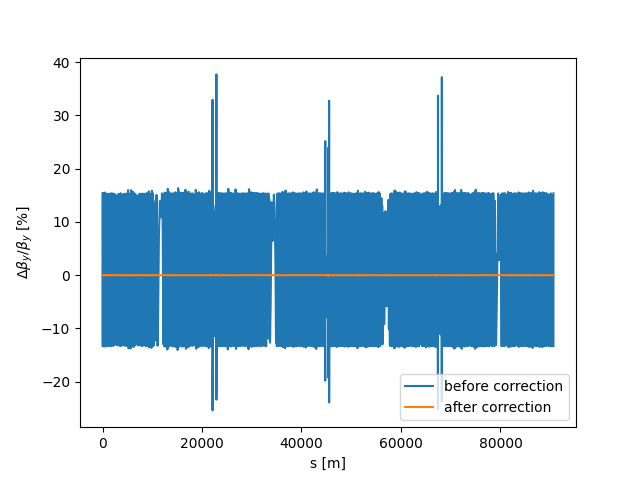

In [22]:
plt.figure()
plt.plot(tw_sol_on.s, 100 * (tw_sol_on.bety/tw_sol_off.bety - 1), label='before correction')
plt.plot(tw_sol_on.s, 100 * (tw_sol_on_corrected.bety/tw_sol_off.bety - 1), label='after correction')
plt.ylabel(r'$\Delta \beta_y / \beta_y$ [%]')
plt.legend()
plt.xlabel('s [m]')

|C-| before:  0.00032023446410065095
|C-| after :  7.272028404854147e-07


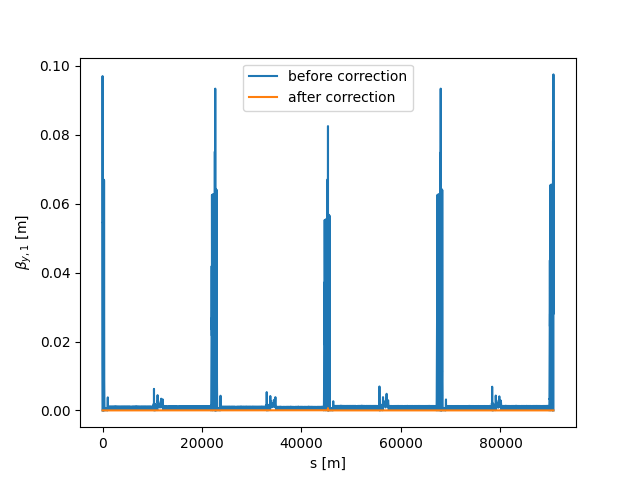

In [23]:
# Coupling
plt.figure()
plt.plot(tw_sol_on.s, tw_sol_on.bety1, label='before correction')
plt.plot(tw_sol_on.s, tw_sol_on_corrected.bety1, label='after correction')
plt.ylabel(r'$\beta_{y,1}$ [m]')
plt.legend()
plt.xlabel('s [m]')

print('|C-| before: ', tw_sol_on.c_minus)
print('|C-| after : ', tw_sol_on_corrected.c_minus)

Text(0.5, 0, 's [m]')

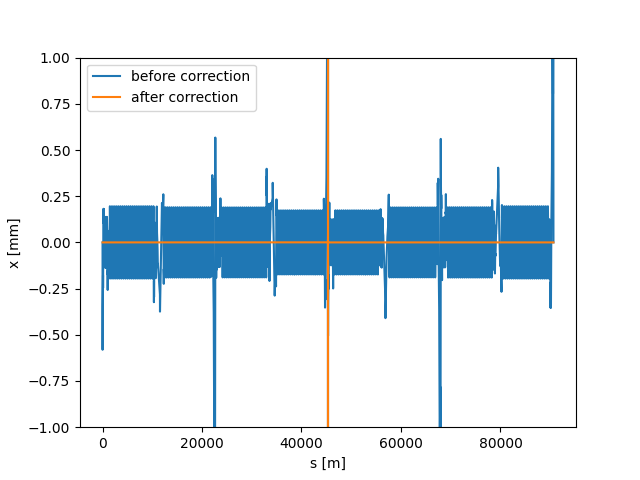

In [24]:
# Orbit
plt.figure()
plt.plot(tw_sol_on.s, 1000 * tw_sol_on.x, label='before correction')
plt.plot(tw_sol_on.s, 1000 * tw_sol_on_corrected.x, label='after correction')
plt.ylabel(r'x [mm]')
plt.ylim(-1,1)
plt.legend()
plt.xlabel('s [m]')